# 02 - Rule Coverage Analysis

Stage 2: apply regex rules to the preprocessed dataset and analyze
coverage, precision proxies, and matched spans.

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.data_ingest import ingest
from src.preprocess import preprocess_dataframe
from src.rule_miner import RuleMiner

In [3]:
DATA_PATH = '../../data/raw/comments.json'

df = ingest(DATA_PATH)
df = preprocess_dataframe(df)
print(f"Preprocessed {len(df)} comments")

[2026-02-17 16:54:23] src.data_ingest INFO: Ingesting comments.json  (format=json)
[2026-02-17 16:54:24] src.data_ingest INFO: Loaded JSON  rows=209049
[2026-02-17 16:54:25] src.data_ingest INFO: Applying field aliases: {'cid': 'comment_id', 'votes': 'like_count', 'time_parsed': 'published_at'}
[2026-02-17 16:54:25] src.data_ingest INFO: Optional column 'video_id' not present; filling with None.
[2026-02-17 16:54:25] src.data_ingest INFO: Optional column 'language' not present; filling with None.
[2026-02-17 16:54:25] src.data_ingest INFO: 14074 rows contain emoji-only text.
[2026-02-17 16:54:29] src.data_ingest INFO: Schema validation complete.  209049 valid rows retained.
[2026-02-17 16:54:29] src.data_ingest INFO: Profiling complete: 209049 rows, 0 nulls in text, 0 duplicates.
[2026-02-17 16:54:29] src.data_ingest INFO: Ingestion complete: 209049 rows ingested from comments.json.


Preprocessed 209049 comments


## Apply Rules

In [4]:
miner = RuleMiner()
df = miner.match_dataframe(df)
report = miner.coverage_report(df)
report

{'total_rows': 209049,
 'any_rule_hit': 208,
 'any_rule_hit_pct': 0.1,
 'per_label': {'AFFECTIVE_PREPACKAGING': {'hits': 18,
   'hit_pct': 0.01,
   'avg_confidence': 0.7956},
  'COMMODIFICATION_MARKET_LOGIC': {'hits': 51,
   'hit_pct': 0.02,
   'avg_confidence': 0.8076},
  'FORMAL_RESISTANCE': {'hits': 53, 'hit_pct': 0.03, 'avg_confidence': 0.6638},
  'PSEUDO_INDIVIDUALIZATION': {'hits': 1,
   'hit_pct': 0.0,
   'avg_confidence': 0.88},
  'REGRESSIVE_LISTENING': {'hits': 17,
   'hit_pct': 0.01,
   'avg_confidence': 0.82},
  'STANDARDIZATION': {'hits': 69, 'hit_pct': 0.03, 'avg_confidence': 0.808}}}

## Coverage Bar Chart

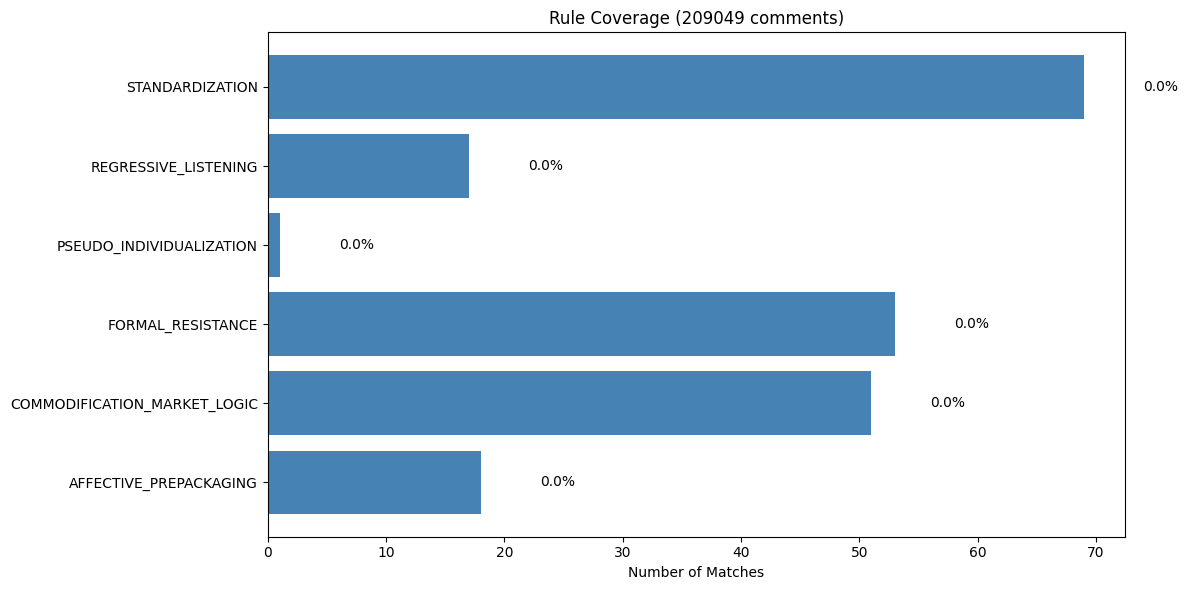

In [9]:
labels = list(report['per_label'].keys())
hits = [report['per_label'][l]['hits'] for l in labels]
pcts = [report['per_label'][l]['hit_pct'] for l in labels]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(labels, hits, color='steelblue')
for bar, pct in zip(bars, pcts):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
            f'{pct:.1f}%', va='center')
ax.set_xlabel('Number of Matches')
ax.set_title(f'Rule Coverage ({report["total_rows"]} comments)')
plt.tight_layout()
plt.show()

## Confidence Distribution per Label

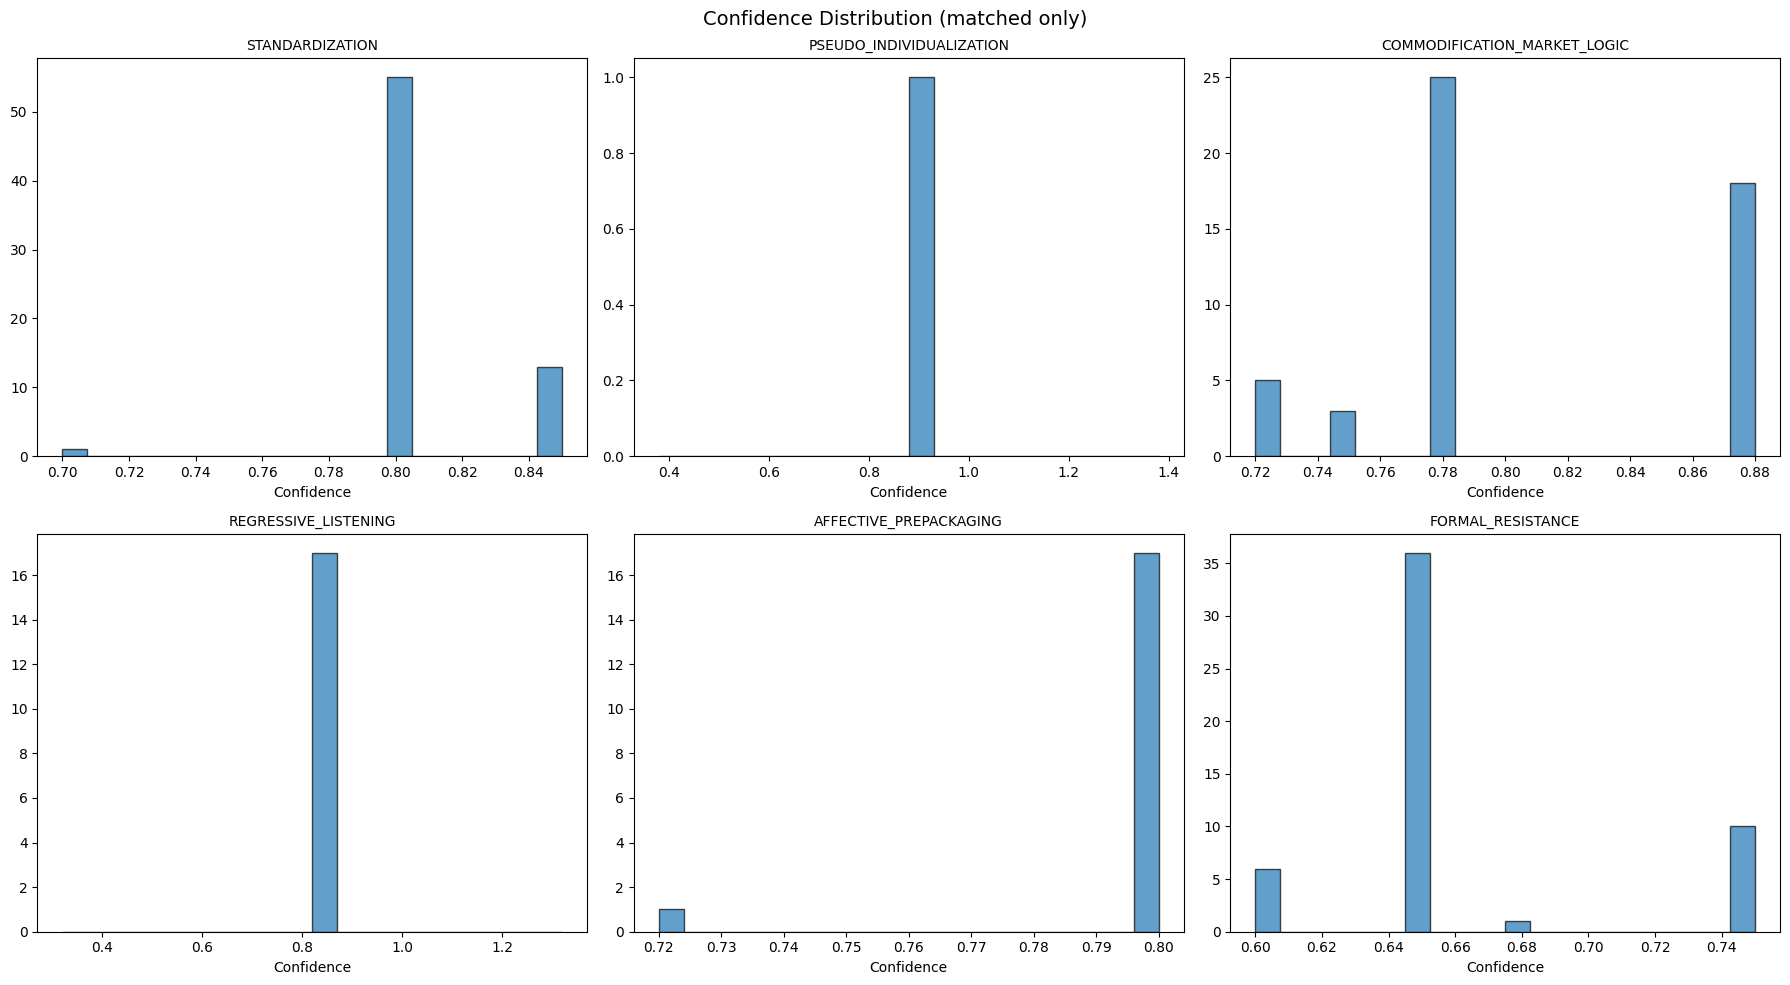

In [6]:
CRITIQUE_LABELS = [
    'STANDARDIZATION', 'PSEUDO_INDIVIDUALIZATION',
    'COMMODIFICATION_MARKET_LOGIC', 'REGRESSIVE_LISTENING',
    'AFFECTIVE_PREPACKAGING', 'FORMAL_RESISTANCE'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, lbl in zip(axes.flat, CRITIQUE_LABELS):
    col = f'rule_{lbl}_conf'
    matched = df[df[f'rule_{lbl}'] == True][col]
    if len(matched) > 0:
        ax.hist(matched, bins=20, edgecolor='black', alpha=0.7)
    ax.set_title(lbl, fontsize=10)
    ax.set_xlabel('Confidence')
plt.suptitle('Confidence Distribution (matched only)', fontsize=14)
plt.tight_layout()
plt.show()

## Sample Matched Comments

In [7]:
for lbl in CRITIQUE_LABELS:
    matched = df[df[f'rule_{lbl}'] == True]
    if len(matched) > 0:
        print(f"\n--- {lbl} ({len(matched)} hits) ---")
        for _, row in matched.head(3).iterrows():
            print(f"  [{row[f'rule_{lbl}_conf']:.2f}] {row['clean_text'][:120]}")


--- STANDARDIZATION (69 hits) ---
  [0.80] I don’t know if ‘smoking out the window’ is considered cookie cutter ... but his songs as Silk Sonic are fun and dynamic
  [0.80] He is literally the most mid artist. Good voice, fine performance and showmanship. But no range, with little to no artis
  [0.85] It's nasalgoc cause my mate said it uses the same beat from 1 of brunomars older songs

--- PSEUDO_INDIVIDUALIZATION (1 hits) ---
  [0.88] It’s giving manufactured personality

--- COMMODIFICATION_MARKET_LOGIC (51 hits) ---
  [0.72] This is what most artists used to do before the 2000s: disappear for two or three years minimum, live some life out of H
  [0.78] this is the most stupid comments threads i’ve just read.. like wtf man? jazz is a genre, and not EVERYBODY likes jazz, i
  [0.88] The MOST successful industry plant

--- REGRESSIVE_LISTENING (17 hits) ---
  [0.82] This is elevator music
  [0.82] Stupid video but i like the song all right good elevator music
  [0.82] And Alicia Keys